In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from haversine import haversine
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from math import sqrt


%matplotlib inline

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)

In [4]:
train_filepath = './datasets/encoded_X_train.csv'
test_filepath = './datasets/encoded_X_test.csv'
y_train_filepath = './datasets/y_train.csv'


X_train_encoded = pd.read_csv(train_filepath)
X_test_encoded = pd.read_csv(test_filepath)
y_train = pd.read_csv(y_train_filepath).squeeze()

X_train_encoded.head()

,flat_model_2-room,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,tranc_year,tranc_month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,...,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,latitude,longitude,planning_area,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude,average_dist_amenities,count_of_convenience_within_1km,house_coord,distance_to_cityhall,pri_sch_rank,sec_sch_rank,pri_sch_rank_X_distance,sec_sch_rank_X_distance
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,2012,7,4,7,9,8,522908.365193,"153, BISHAN ST 13",1399.320,34,9,1987,Y,...,0,0,0,0,0,0,536247.390101,1.346086,103.855078,625788.359629,866.941448,0.0,1.0,3.0,640.151925,0.0,1.0,7.0,80,77,903.659703,Bishan,1,1,1.350580,103.848305,58.207761,623503.862281,1.345659,103.855381,415.607357,Kuo Chuan Presbyterian Primary School,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892,504.406687,4.0,"(1.346085959, 103.8550783)",5894.847771,2,2,831.214714,895.788799
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,2013,7,7,13,15,14,620388.635767,"289B, BT BATOK ST 25",1550.016,24,16,1996,Y,...,0,0,0,0,0,0,564288.621784,1.343867,103.760535,398816.025932,1459.579948,0.0,0.0,4.0,1762.082341,0.0,0.0,1.0,84,95,1334.251197,Bukit Batok,1,0,1.349561,103.749970,214.747860,516462.046776,1.344064,103.758613,498.849039,Keming Primary School,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013,952.482609,1.0,"(1.343866875, 103.760535)",11633.683375,1,3,498.849039,540.223673
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,2012,4,2,1,5,3,456235.760726,"232, BISHAN ST 22",1108.692,29,11,1990,Y,...,0,0,0,0,0,0,459432.932676,1.358245,103.845504,625788.359629,950.175199,0.0,1.0,4.0,726.215262,0.0,1.0,9.0,32,86,907.453484,Bishan,1,1,1.350580,103.848305,43.396521,737111.777260,1.358045,103.845169,389.515528,Catholic High School,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934,516.645199,4.0,"(1.358245182, 103.8455043)",7274.162586,1,1,389.515528,389.515528
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,2017,12,1,1,3,2,376340.416717,"876, YISHUN ST 81",893.412,34,4,1987,Y,...,0,0,0,

# Running Models and Benchmarking

In [5]:
# Define functions for Linear Regression Workflow first


def create_model(train_X, val_X, train_y, val_y):
    lr = LinearRegression()
    lr.fit(train_X, train_y)
    y_preds = lr.predict(val_X)
    rmse = np.sqrt(mean_squared_error(val_y, y_preds))
    r2_train = lr.score(train_X, train_y)
    r2_val = lr.score(val_X, val_y)
    return rmse, r2_train, r2_val, lr
    

def create_baseline_score(train_X, train_y, cv=5, scoring='neg_root_mean_squared_error'):
    lr = LinearRegression()
    baseline_rmse = -1 * cross_val_score(lr, train_X, train_y, cv=cv, scoring=scoring).mean()
    return baseline_rmse
    

def ordinary_linreg(X_train, y_train, X_test, X_features, 
                    with_poly=False, 
                    include_bias=True, 
                    interaction_only=False, 
                    poly_degree=2,
                    standardscale=True):
    
    
    X_train = X_train[X_features]
    y_train = y_train
    X_test = X_test[X_features]
    
    if with_poly:
        poly = PolynomialFeatures(include_bias=include_bias, interaction_only=interaction_only, degree=poly_degree)
        poly_X_train = poly.fit_transform(X_train)
        poly_X_test = poly.transform(X_test)
        
        if standardscale:
            ss = StandardScaler()
            Z_train = ss.fit_transform(poly_X_train)
            Z_test = ss.transform(poly_X_test) 
            train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
            rmse, r2_train, r2_val, fitted_model = create_model(train_X, val_X, train_y, val_y)
            baseline_rmse = create_baseline_score(Z_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
            print(f'RMSE: {rmse}')
            print(f'R2_train: {r2_train}')
            print(f'R2_val: {r2_val}')
            print(f'Baseline cross-val_score: {baseline_rmse}')
            print(f'Number of features: {len(fitted_model.coef_)}')
            return fitted_model, Z_test
        else:
            train_X, val_X, train_y, val_y = train_test_split(poly_X_train, y_train, random_state=0)
            rmse, r2_train, r2_val, fitted_model = create_model(train_X, val_X, train_y, val_y)
            baseline_rmse = create_baseline_score(poly_X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
            print(f'RMSE: {rmse}')
            print(f'R2_train: {r2_train}')
            print(f'R2_val: {r2_val}')
            print(f'Baseline cross-val_score: {baseline_rmse}')
            print(f'Number of features: {len(fitted_model.coef_)}')
            return fitted_model, poly_X_test
    
        
    elif standardscale:
        ss = StandardScaler()
        Z_train = ss.fit_transform(X_train)
        Z_test = ss.transform(X_test) 
        train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
        rmse, r2_train, r2_val, fitted_model = create_model(train_X, val_X, train_y, val_y)
        baseline_rmse = create_baseline_score(Z_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
        print(f'RMSE: {rmse}')
        print(f'R2_train: {r2_train}')
        print(f'R2_val: {r2_val}')
        print(f'Baseline cross-val_score: {baseline_rmse}')
        print(f'Number of features: {len(fitted_model.coef_)}')
        return fitted_model, Z_test

    else:  # no standardscaling
        train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, random_state=0)
        rmse, r2_train, r2_val, fitted_model = create_model(train_X, val_X, train_y, val_y)
        baseline_rmse = create_baseline_score(X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
        print(f'RMSE: {rmse}')
        print(f'R2_train: {r2_train}')
        print(f'R2_val: {r2_val}')
        print(f'Baseline cross-val_score: {baseline_rmse}')
        print(f'Number of features: {len(fitted_model.coef_)}')
        return fitted_model, X_test
    
    

def ridgeCV(X_train, y_train, X_test, X_features, 
                    with_poly=False, 
                    include_bias=True, 
                    interaction_only=False, 
                    poly_degree=2,
                    ):
    
    
    X_train = X_train[X_features]
    y_train = y_train
    X_test = X_test[X_features]
    
    if with_poly:
        poly = PolynomialFeatures(include_bias=include_bias, interaction_only=interaction_only, degree=poly_degree)
        poly_X_train = poly.fit_transform(X_train)
        poly_X_test = poly.transform(X_test)
        ss = StandardScaler()
        Z_train = ss.fit_transform(poly_X_train)
        Z_test = ss.transform(poly_X_test) 
        
        r_alphas = np.logspace(0,5,100)
        train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
        ridge_cv = RidgeCV(alphas=r_alphas, scoring='neg_mean_squared_error', cv=5)
        ridge_cv.fit(train_X, train_y)
        y_preds = ridge_cv.predict(val_X)
        rmse = sqrt(mean_squared_error(val_y, y_preds))
        print(f'Number of features: {len(ridge_cv.coef_)}')
        print(f'RMSE: {rmse}')
        return ridge_cv, Z_test
        
    else:
        ss = StandardScaler()
        Z_train = ss.fit_transform(X_train)
        Z_test = ss.transform(X_test) 
        
        r_alphas = np.logspace(0,5,100)
        train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
        ridge_cv = RidgeCV(alphas=r_alphas, scoring='neg_mean_squared_error', cv=5)
        ridge_cv.fit(Z_train, y_train)
        y_preds = ridge_cv.predict(val_X)
        rmse = sqrt(mean_squared_error(val_y, y_preds))
        print(f'Number of features: {len(ridge_cv.coef_)}')
        print(f'RMSE: {rmse}')
        return ridge_cv, Z_test
    
    

    
def lassoCV(X_train, y_train, X_test, X_features, 
                    with_poly=False, 
                    include_bias=True, 
                    interaction_only=False, 
                    poly_degree=2,
                    ):
    
    
    X_train = X_train[X_features]
    y_train = y_train
    X_test = X_test[X_features]
    
    if with_poly:
        poly = PolynomialFeatures(include_bias=include_bias, interaction_only=interaction_only, degree=poly_degree)
        poly_X_train = poly.fit_transform(X_train)
        poly_X_test = poly.transform(X_test)
        ss = StandardScaler()
        Z_train = ss.fit_transform(poly_X_train)
        Z_test = ss.transform(poly_X_test) 
        
        l_alphas = np.logspace(-3,0,100)
        train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
        lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)
        lasso_cv.fit(train_X, train_y)
        y_preds = lasso_cv.predict(val_X)
        rmse = sqrt(mean_squared_error(val_y, y_preds))
        print(f'Number of features: {len(lasso_cv.coef_)}')
        print(f'RMSE: {rmse}')
        return lasso_cv, Z_test
        
    else:
        ss = StandardScaler()
        Z_train = ss.fit_transform(X_train)
        Z_test = ss.transform(X_test) 
        
        l_alphas = np.logspace(-3,0,100)
        train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
        lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)
        lasso_cv.fit(train_X, train_y)
        y_preds = lasso_cv.predict(val_X)
        rmse = sqrt(mean_squared_error(val_y, y_preds))
        print(f'Number of features: {len(lasso_cv.coef_)}')
        print(f'RMSE: {rmse}')
        return lasso_cv, Z_test

In [6]:
# Select X features to train on here

X_features = ['floor_area_sqm',
                'postal',  
                'bus_stop_name',
                'full_flat_type',
                'planning_area',
                'hdb_age',
                'total_dwelling_units', 
                'mid_storey',
                'max_floor_lvl',
                'mrt_nearest_distance',
                'hawker_nearest_distance',
                'bus_stop_nearest_distance',
                'count_of_convenience_within_1km',
                'average_dist_amenities',
                'pri_sch_nearest_distance',
                'pri_sch_rank',
                'sec_sch_rank',
                'distance_to_cityhall',
             ]



In [7]:
# Fitting LinReg model and raising degree of polynomial to 4, with standard-scaling

fitted_model, transformed_X_test = ordinary_linreg(X_train_encoded, y_train, X_test_encoded, X_features, 
                                                   with_poly=True, 
                                                   poly_degree=4, 
                                                   standardscale=True)

RMSE: 37767.6755850952
R2_train: 0.9420000393394152
R2_val: 0.9302443486140911
Baseline cross-val_score: 38626.79342914205
Number of features: 7315


In [10]:
# Fitting a simple LinReg without raising polynomials with standard-scaling

fitted_model_2, transformed_X_test = ordinary_linreg(X_train_encoded, y_train, X_test_encoded, X_features, 
                                 with_poly=False, 
                                 poly_degree=4, 
                                 standardscale=True)

RMSE: 54859.515403508434
R2_train: 0.8543157504303076
R2_val: 0.8528220265671858
Baseline cross-val_score: 54628.91162761218
Number of features: 18


In [19]:
# Run optimal feature set with RidgeCV

ridge_model, transformed_X_test = ridgeCV(X_train_encoded, y_train, X_test_encoded, X_features, 
                        with_poly=False, 
                        poly_degree=4)

Number of features: 18
RMSE: 54834.83141608184


In [20]:
# Run optimal feature set with LassoCV

lasso_model, transformed_X_test = lassoCV(X_train_encoded, y_train, X_test_encoded, X_features, 
                        with_poly=False, 
                        poly_degree=4)

Number of features: 18
RMSE: 54859.12329108551


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.072e+11, tolerance: 1.717e+11
  model = cd_fast.enet_coordinate_descent(


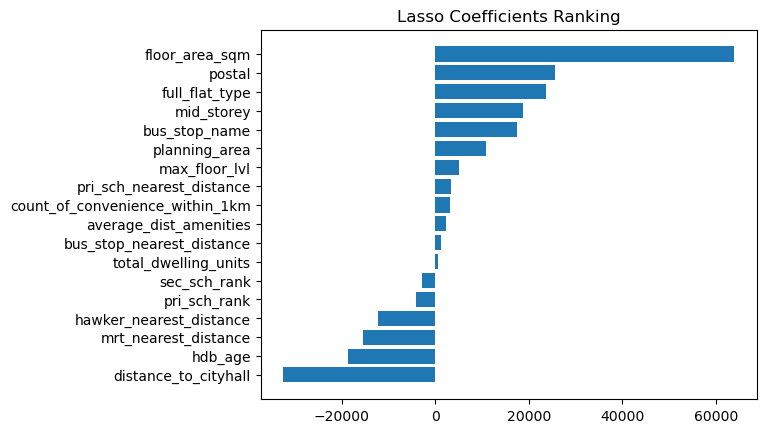

<Figure size 10000x20000 with 0 Axes>

In [44]:
# Plot optimal Lasso model coefficients

lasso_coefficients = pd.Series(lasso_model.coef_, index=X_features).sort_values(ascending=True)

width = np.arange(len(lasso_coefficients))
ticks = list(lasso_coefficients.index)
plt.barh(width, lasso_coefficients)
plt.yticks(width, ticks)
plt.title("Lasso Coefficients Ranking")

plt.figure(dpi=500,figsize=(20,40));


# total_dwelling_units, bus_stop_nearest_distance, average_dist_amenities are closest to 0 per Lasso rankings

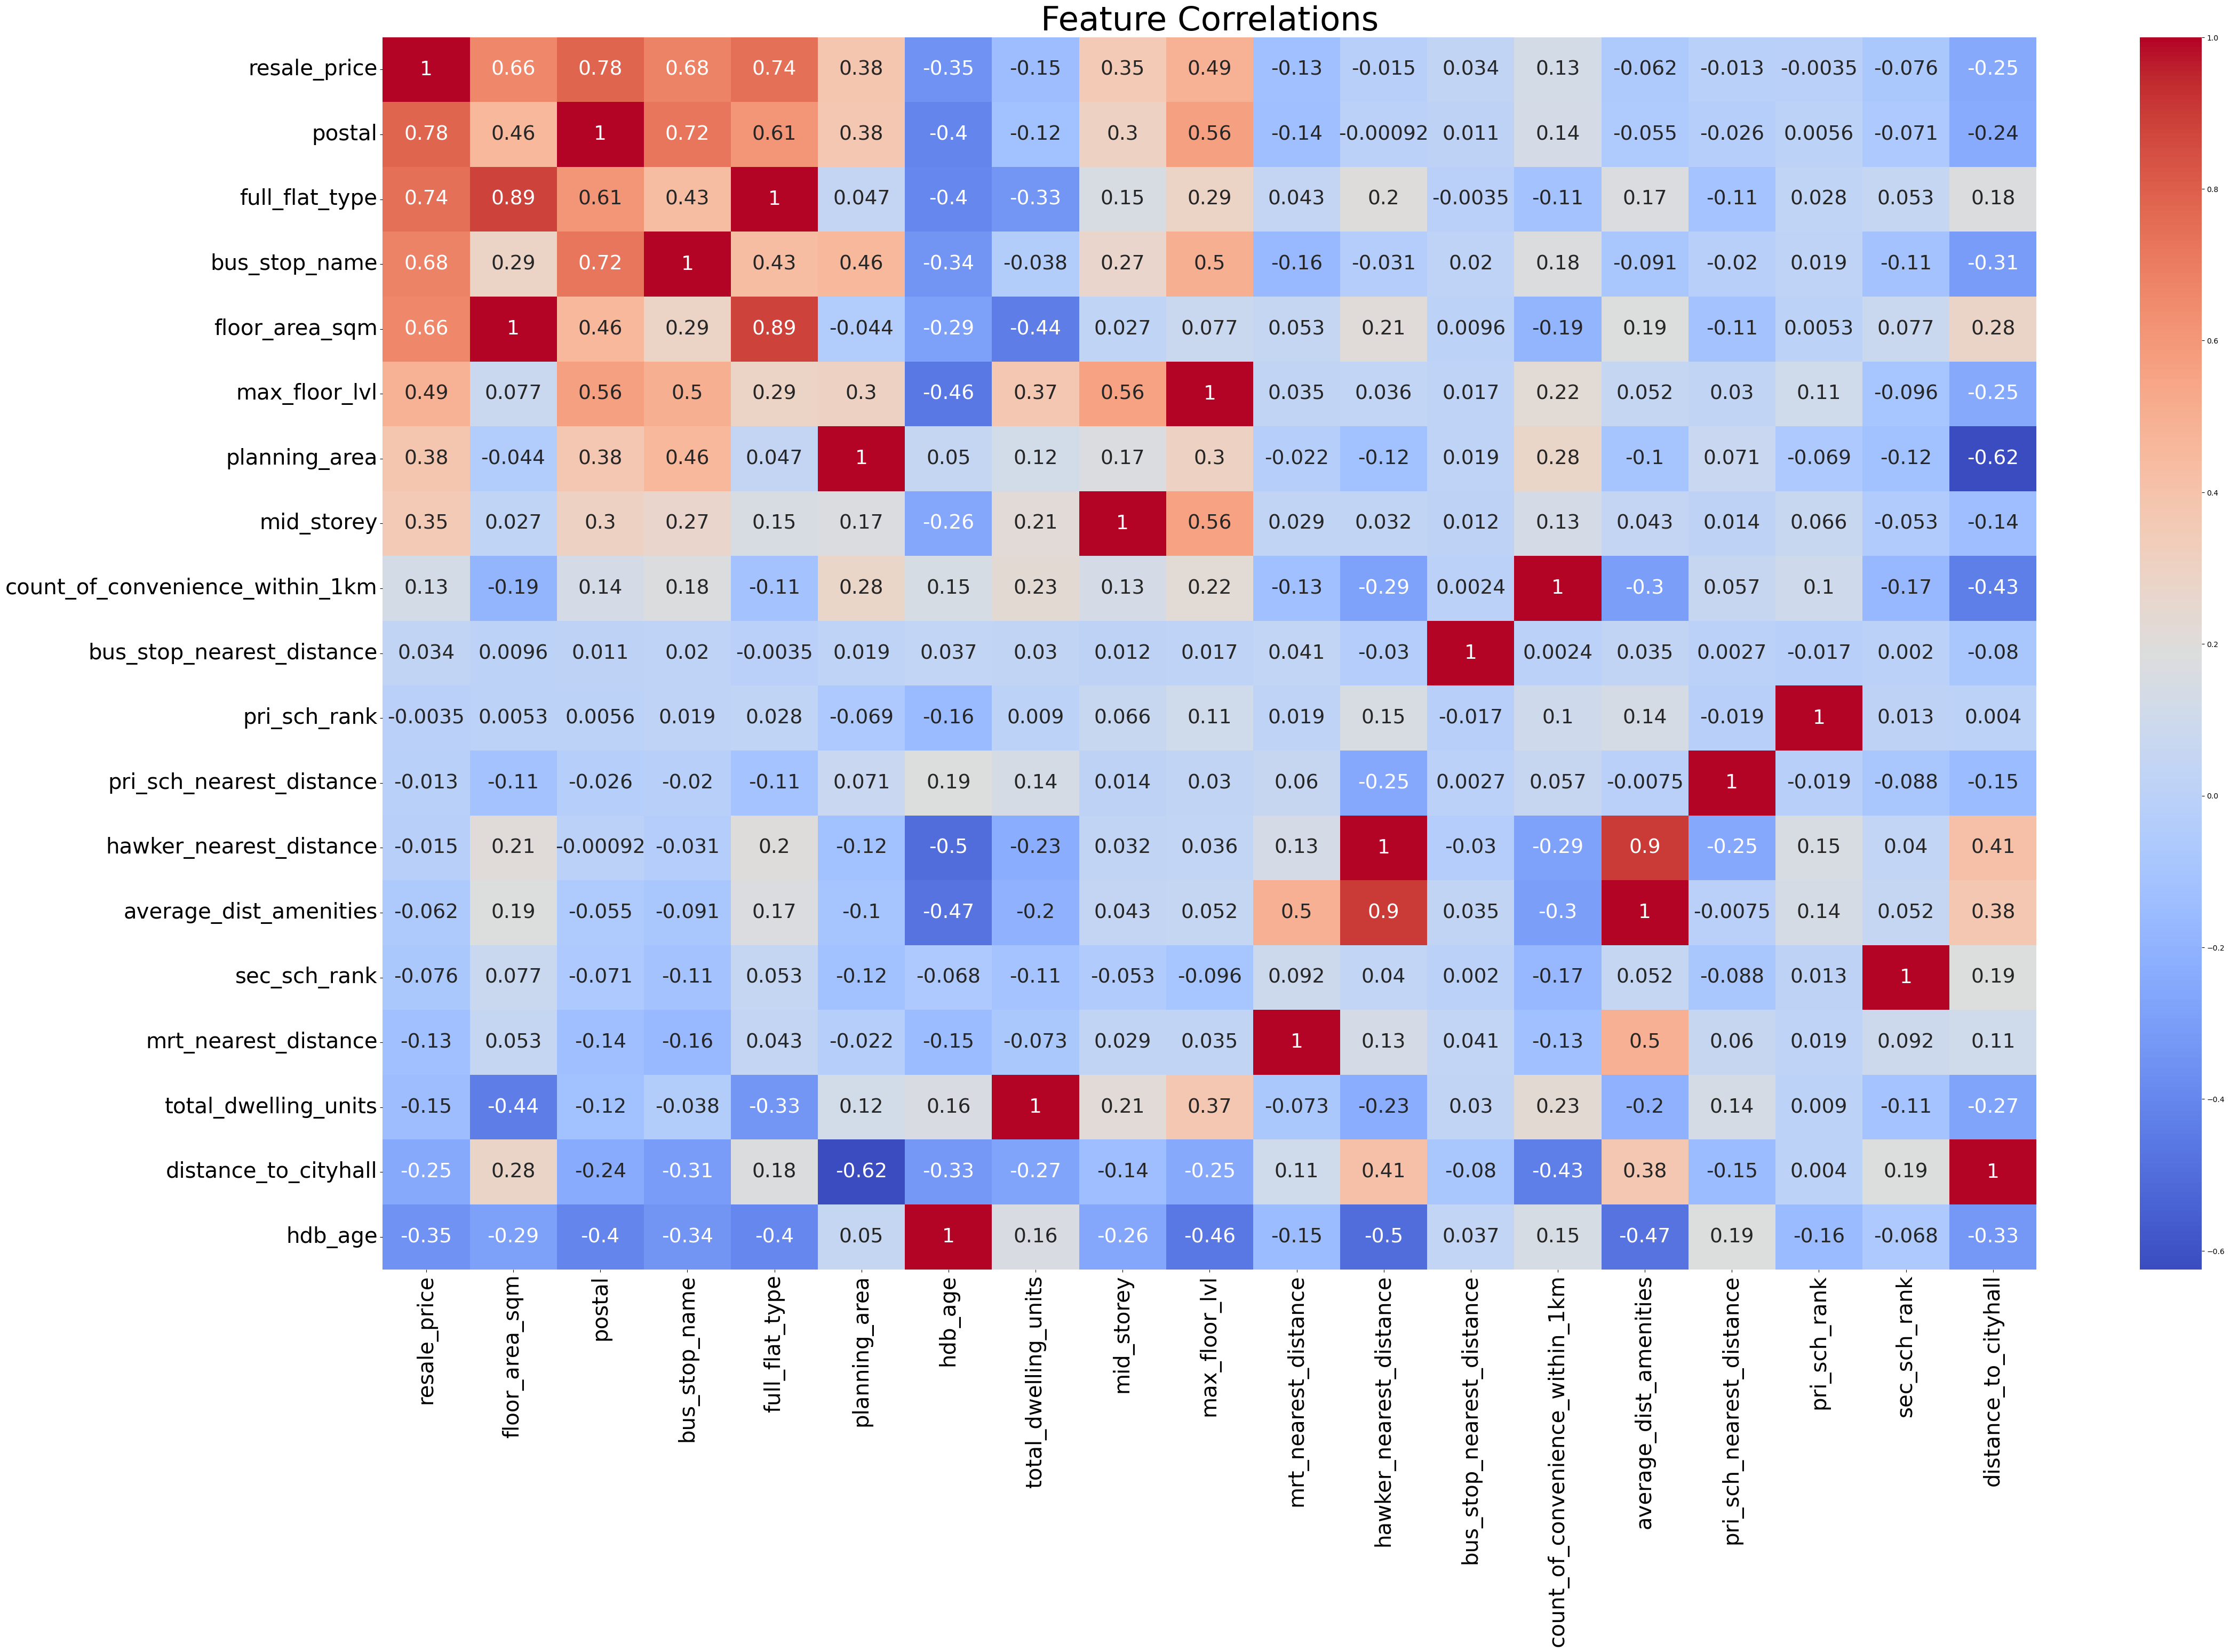

In [29]:
# Correlation heatmap of selected features

X_train_correlations = X_train_encoded[X_features].copy().corr()
X_train_encoded_with_resale_prices['resale_price'] = y_train
X_train_correlations = X_train_encoded_with_resale_prices.corr()
X_train_correlations.insert(0, 'resale_price', X_train_correlations.pop('resale_price'))   # shift resale_price col to leftmost
X_train_correlations = X_train_correlations.sort_values('resale_price', ascending=False)  # sort corr in the first col

plt.figure(figsize=(50,30))
sns.heatmap(X_train_correlations, cmap='coolwarm', annot=True, annot_kws={"fontsize": 27})
plt.tick_params(axis='both', labelsize=29)
plt.title("Feature Correlations", fontsize=45);

# Part 2: Model Results Evaluation

|Model|Std.Scaled|Num_of_Features|training_RMSE|baseline_RMSE|RidgeCV_RMSE|LassoCV_RMSE|Polynomial_4_train_RMSE|Polynomial_4_baseline_RMSE|Num_of_Poly_Features|Recommended|
|:---|---|:---:|---|---:|---|---|---|---|---|---|
|1|Yes|14|\$ 55,260|\$ 54,975|\$55,240|\$55,261|\$ 38,779|\$ 38,216|3,060|
|2|Yes|15|\$ 54,877|\$ 54,641|\$ 54,855|\$ 54,877|\$ 37,693|\$ 37,654|3,876|
|3|Yes|16|\$ 54,855|\$ 54,624|\$ 54,833|\$ 54,855|\$ 37,671|\$ 37,758|4,845|
|4|Yes|18|\$ 54,860|\$ 54,630|\$ 54,834 |\$ 54,859|\$ 37,760|\$ 37,766|7,315|Yes|
|5|Yes|21|\$ 54,849|\$ 54,609|\$ 54,821|\$ 54,849|n/a|n/a|n/a|
|6|Yes|28|\$ 54,571|\$ 54,314|\$ 54,550|\$54,571|n/a|n/a|n/a|

Beyond a certain number of features and degrees of polynomial, model performance cease to improve meaningfully

For the basic LinReg models, standard-scaling of features hardly affected the performance scores

If there is no overfitting in the basic model, then RidgeCV and LassoCV produces same results. 



### Optimal set of 18 features are: 
    'floor_area_sqm',
    'postal',  
    'bus_stop_name',
    'full_flat_type',
    'planning_area',
    'hdb_age',
    'total_dwelling_units', 
    'mid_storey',
    'max_floor_lvl',
    'mrt_nearest_distance',
    'hawker_nearest_distance',
    'bus_stop_nearest_distance',
    'count_of_convenience_within_1km',
    'average_dist_amenities',
    'pri_sch_nearest_distance',
    'pri_sch_rank',
    'sec_sch_rank',
    'distance_to_cityhall'


# Part 4: Kaggle Submission

In [11]:
original_test_df = pd.read_csv('./datasets/test.csv')

# Using the simple 18-feature model to predict
y_preds = fitted_model_2.predict(transformed_X_test)     # Change fitted_model here will do

# Create csv for Kaggle Submission
submission_csv = pd.DataFrame(columns=['Id', 'Predicted'])
submission_csv['Id'] = original_test_df['id']
submission_csv['Predicted'] = y_preds

submission_csv.to_csv('./datasets/kaggle_submission.csv', index=False)

C:\Users\leagu\AppData\Local\Temp\ipykernel_2492\2598171446.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  original_test_df = pd.read_csv('./datasets/test.csv')
